<a href="https://colab.research.google.com/github/Ishrak-DataScience/Ageing-clock/blob/main/Aging_Clock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

In [ ]:
# 1. GENERATE SAMPLE DATA
# We create a dataset with 200 samples and 6 key protein features (X)
np.random.seed(42)
n_samples = 200

data = {
    'GDF15': np.random.normal(7.5, 1.2, n_samples),      # Mitochondrial stress
    'CRP': np.random.normal(5.0, 0.8, n_samples),        # Inflammation
    'Cystatin_C': np.random.normal(6.2, 0.5, n_samples), # Kidney function
    'NPPB': np.random.normal(4.5, 1.0, n_samples),       # Cardiac stress
    'TIMP1': np.random.normal(8.0, 0.6, n_samples),      # Tissue remodeling
    'IGFBP2': np.random.normal(9.1, 1.1, n_samples)      # Metabolism
}

df = pd.DataFrame(data)

In [ ]:
# Target (Y): Biological Age (calculated as a linear combination + noise)
df['Biological_Age'] = (
    4.5 * df['GDF15'] + 2.1 * df['CRP'] + 5.8 * df['Cystatin_C'] +
    1.2 * df['NPPB'] - 1.5 * df['TIMP1'] + 10 + np.random.normal(0, 3, n_samples)
)

In [ ]:
# 2. PREPARE DATA FOR MODELING
X = df.drop('Biological_Age', axis=1) # Features
y = df['Biological_Age']              # Target

In [ ]:
# Split into Training (80%) and Testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. TRAIN THE LINEAR REGRESSION MODEL
model = LinearRegression()
model.fit(X_train, y_train)

In [ ]:



# 4. PREDICT AND EVALUATE
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)










print(f"Mean Absolute Error: {mae:.2f} years")
print(f"R-squared Score: {r2:.2f}")



In [ ]:
# 5. VISUALIZE RESULTS
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal', label='Samples')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Biological Age')
plt.xlabel('Actual Age (Years)')
plt.ylabel('Predicted Age (Years)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

In [1]:
#A real example
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
#google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 1. Load and Preprocess Data
bio_age_df = pd.read_csv('/content/drive/MyDrive/Ageing_clock/bioAge.csv')
gen_exp_df = pd.read_csv('/content/drive/MyDrive/Ageing_clock/genExp.csv')
df = pd.merge(gen_exp_df, bio_age_df, on='colID')

X = df.drop(['colID', 'bioAge'], axis=1).values
y = df['bioAge'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [12]:
# 2. Define the PyTorch Model
class ProteomicClock(nn.Module):
    def __init__(self, input_dim):
        super(ProteomicClock, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)

input_dim = X_train.shape[1]
model = ProteomicClock(input_dim)

In [13]:
# 3. Training Setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # weight_decay is L2 reg

# 4. Training Loop
epochs = 150
train_losses = []
val_maes = []

In [15]:
# 3. Training Loop
for epoch in range(epochs):
    model.train()
    batch_losses = []
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_losses.append(np.mean(batch_losses))
    # Validation
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test_tensor)
        val_mae = mean_absolute_error(y_test, test_preds.numpy())
        val_maes.append(val_mae)

In [16]:
# 5. Final Evaluation
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy().flatten()

In [17]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"PyTorch Model Results:")
print(f"Final Test MAE: {mae:.2f}")
print(f"Final Test R2: {r2:.2f}")

PyTorch Model Results:
Final Test MAE: 8.97
Final Test R2: -0.64


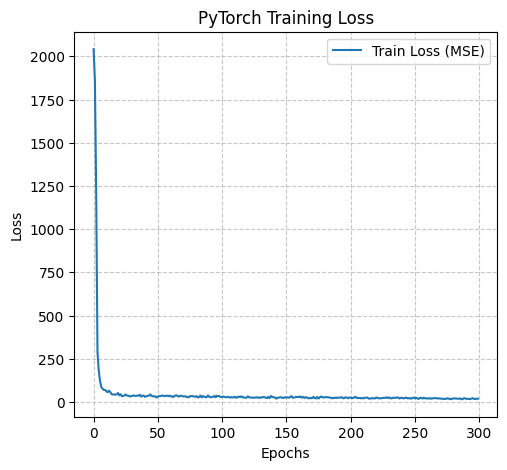

In [18]:
# 6. Visualization
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (MSE)')
plt.title('PyTorch Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

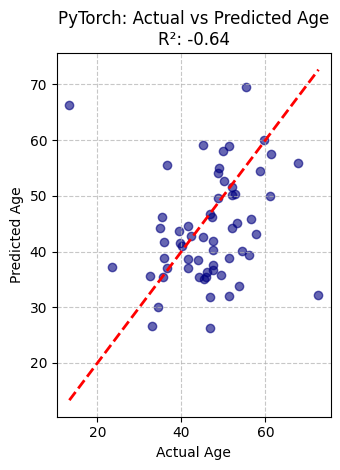

In [19]:
# Plot Actual vs Predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, color='navy', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title(f'PyTorch: Actual vs Predicted Age\nR²: {r2:.2f}')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('pytorch_results.png')